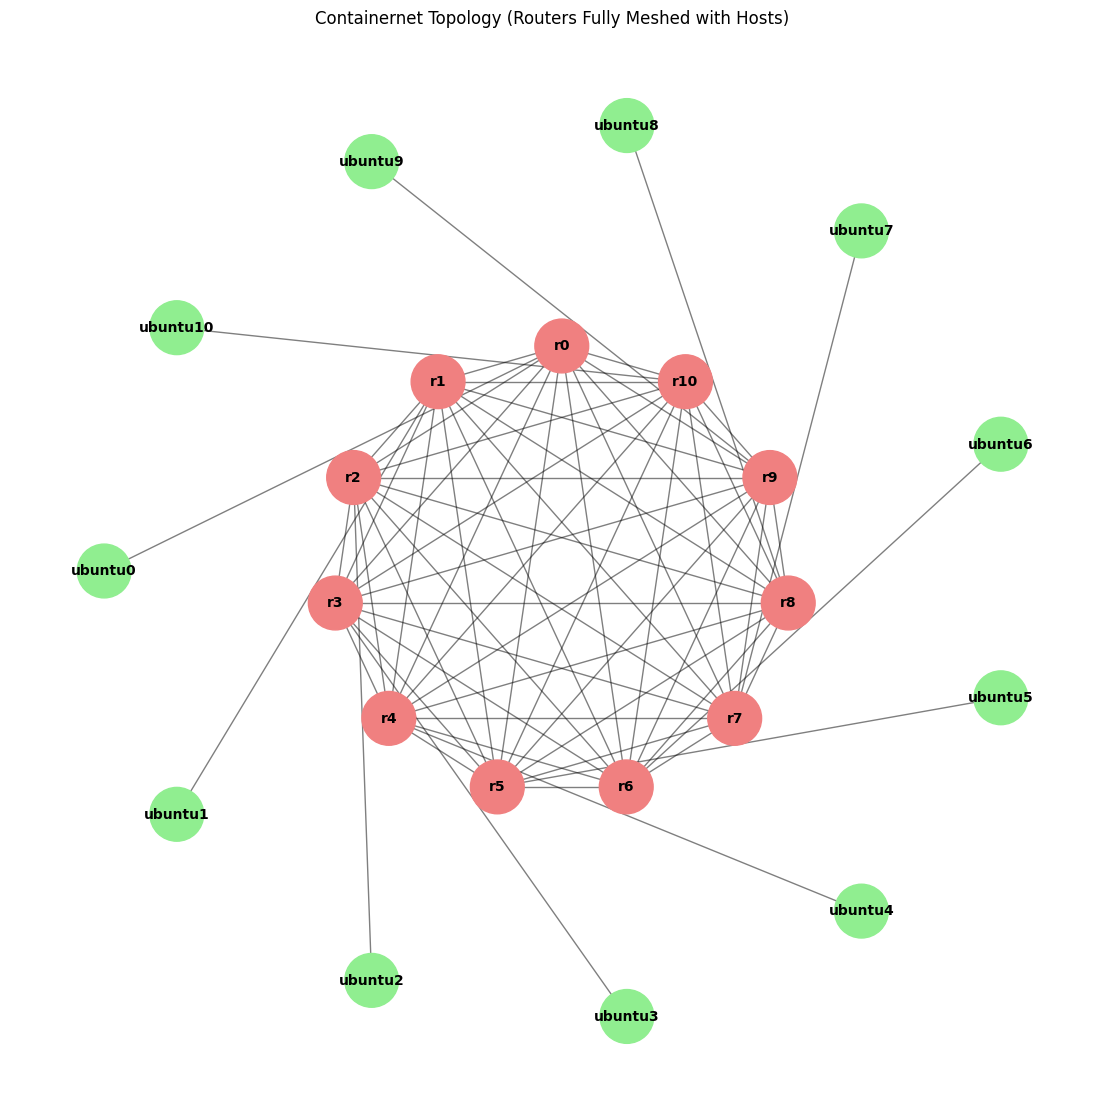

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

# Routers (r0 to r10)
routers = [f"r{i}" for i in range(11)]
# Hosts (ubuntu0 to ubuntu10)
hosts = [f"ubuntu{i}" for i in range(11)]

# Add nodes with attributes
for r in routers:
    G.add_node(r, node_type='router')

for h in hosts:
    G.add_node(h, node_type='host')

# Add router-router edges (fully connected mesh based on dump pattern)
for i in range(len(routers)):
    for j in range(i + 1, len(routers)):
        G.add_edge(routers[i], routers[j])

# Add router-host edges (each router connects to its corresponding host)
for i in range(len(routers)):
    G.add_edge(routers[i], hosts[i])

# Define layout: routers on inner circle, hosts on outer circle
shell_layout = [routers, hosts]
pos = nx.shell_layout(G, nlist=shell_layout)

# Define colors
node_colors = []
for node in G.nodes(data=True):
    if node[1]['node_type'] == 'router':
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightgreen')

# Draw the graph
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title("Containernet Topology (Routers Fully Meshed with Hosts)")
plt.axis('off')
plt.show()


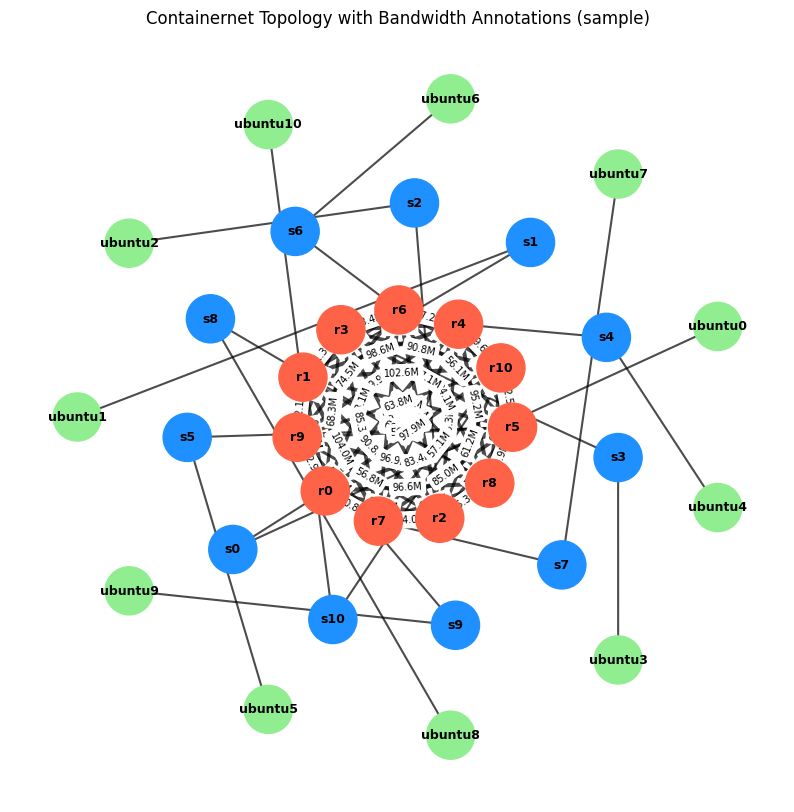

In [7]:
import re
import networkx as nx
import matplotlib.pyplot as plt

# Raw CLI output (trimmed to keep example concise – include all lines in real use)
link_data = """
s0-eth1 <-> r0-eth0  bw=Mbps  delay=  loss=%  q=
s1-eth1 <-> r1-eth0  bw=Mbps  delay=  loss=%  q=
s2-eth1 <-> r2-eth0  bw=Mbps  delay=  loss=%  q=
s3-eth1 <-> r3-eth0  bw=Mbps  delay=  loss=%  q=
s4-eth1 <-> r4-eth0  bw=Mbps  delay=  loss=%  q=
s5-eth1 <-> r5-eth0  bw=Mbps  delay=  loss=%  q=
s6-eth1 <-> r6-eth0  bw=Mbps  delay=  loss=%  q=
s7-eth1 <-> r7-eth0  bw=Mbps  delay=  loss=%  q=
s8-eth1 <-> r8-eth0  bw=Mbps  delay=  loss=%  q=
s9-eth1 <-> r9-eth0  bw=Mbps  delay=  loss=%  q=
s10-eth1 <-> r10-eth0  bw=Mbps  delay=  loss=%  q=
r0-eth1 <-> r1-eth1  bw=95.9785Mbps  delay=4.22315ms  loss=%  q=
r0-eth2 <-> r2-eth1  bw=98.0478Mbps  delay=7.6379ms  loss=%  q=
r0-eth3 <-> r3-eth1  bw=68.2662Mbps  delay=5.87145ms  loss=%  q=
r0-eth4 <-> r4-eth1  bw=99.3139Mbps  delay=6.8088ms  loss=%  q=
r0-eth5 <-> r5-eth1  bw=83.426Mbps  delay=4.4916ms  loss=%  q=
r0-eth6 <-> r6-eth1  bw=83.0869Mbps  delay=6.05765ms  loss=%  q=
r0-eth7 <-> r7-eth1  bw=60.7735Mbps  delay=7.14255ms  loss=%  q=
r0-eth8 <-> r8-eth1  bw=96.6157Mbps  delay=7.07675ms  loss=%  q=
r0-eth9 <-> r9-eth1  bw=92.9202Mbps  delay=6.418ms  loss=%  q=
r0-eth10 <-> r10-eth1  bw=97.8655Mbps  delay=5.82105ms  loss=%  q=
r1-eth2 <-> r2-eth2  bw=90.8298Mbps  delay=5.99835ms  loss=%  q=
r1-eth3 <-> r3-eth2  bw=71.2601Mbps  delay=4.2545ms  loss=%  q=
r1-eth4 <-> r4-eth2  bw=98.5978Mbps  delay=5.21835ms  loss=%  q=
r1-eth5 <-> r5-eth2  bw=85.2993Mbps  delay=4.41735ms  loss=%  q=
r1-eth6 <-> r6-eth2  bw=77.484Mbps  delay=5.5389ms  loss=%  q=
r1-eth7 <-> r7-eth2  bw=103.9588Mbps  delay=5.841ms  loss=%  q=
r1-eth8 <-> r8-eth2  bw=60.0515Mbps  delay=7.3222ms  loss=%  q=
r1-eth9 <-> r9-eth2  bw=102.1442Mbps  delay=4.90365ms  loss=%  q=
r1-eth10 <-> r10-eth2  bw=102.6049Mbps  delay=4.8864ms  loss=%  q=
r2-eth3 <-> r3-eth3  bw=86.4669Mbps  delay=4.9975ms  loss=%  q=
r2-eth4 <-> r4-eth3  bw=75.3185Mbps  delay=6.8805ms  loss=%  q=
r2-eth5 <-> r5-eth3  bw=77.7246Mbps  delay=5.7581ms  loss=%  q=
r2-eth6 <-> r6-eth3  bw=94.2362Mbps  delay=6.5448ms  loss=%  q=
r2-eth7 <-> r7-eth3  bw=103.9833Mbps  delay=7.5362ms  loss=%  q=
r2-eth8 <-> r8-eth3  bw=75.27Mbps  delay=5.28625ms  loss=%  q=
r2-eth9 <-> r9-eth3  bw=56.8118Mbps  delay=4.97055ms  loss=%  q=
r2-eth10 <-> r10-eth3  bw=61.234Mbps  delay=6.0824ms  loss=%  q=
r3-eth4 <-> r4-eth4  bw=96.2693Mbps  delay=4.4182ms  loss=%  q=
r3-eth5 <-> r5-eth4  bw=87.0909Mbps  delay=5.69355ms  loss=%  q=
r3-eth6 <-> r6-eth4  bw=63.4368Mbps  delay=6.7481ms  loss=%  q=
r3-eth7 <-> r7-eth4  bw=85.2728Mbps  delay=6.72625ms  loss=%  q=
r3-eth8 <-> r8-eth4  bw=66.2665Mbps  delay=6.4879ms  loss=%  q=
r3-eth9 <-> r9-eth4  bw=78.7714Mbps  delay=6.02505ms  loss=%  q=
r3-eth10 <-> r10-eth4  bw=90.7527Mbps  delay=7.1696ms  loss=%  q=
r4-eth5 <-> r5-eth5  bw=99.9713Mbps  delay=5.9879ms  loss=%  q=
r4-eth6 <-> r6-eth5  bw=57.2017Mbps  delay=4.3557ms  loss=%  q=
r4-eth7 <-> r7-eth5  bw=79.3775Mbps  delay=6.3829ms  loss=%  q=
r4-eth8 <-> r8-eth5  bw=95.2467Mbps  delay=7.5609ms  loss=%  q=
r4-eth9 <-> r9-eth5  bw=89.9151Mbps  delay=7.7912ms  loss=%  q=
r4-eth10 <-> r10-eth5  bw=99.5954Mbps  delay=6.6415ms  loss=%  q=
r5-eth6 <-> r6-eth6  bw=56.1264Mbps  delay=6.1324ms  loss=%  q=
r5-eth7 <-> r7-eth6  bw=85.0384Mbps  delay=4.937ms  loss=%  q=
r5-eth8 <-> r8-eth6  bw=90.9213Mbps  delay=6.3279ms  loss=%  q=
r5-eth9 <-> r9-eth6  bw=56.0351Mbps  delay=7.2403ms  loss=%  q=
r5-eth10 <-> r10-eth6  bw=82.5418Mbps  delay=4.67975ms  loss=%  q=
r6-eth7 <-> r7-eth7  bw=87.7056Mbps  delay=7.33665ms  loss=%  q=
r6-eth8 <-> r8-eth7  bw=84.1187Mbps  delay=5.45285ms  loss=%  q=
r6-eth9 <-> r9-eth7  bw=74.5212Mbps  delay=6.03995ms  loss=%  q=
r6-eth10 <-> r10-eth7  bw=85.3216Mbps  delay=4.3336ms  loss=%  q=
r7-eth8 <-> r8-eth8  bw=65.3389Mbps  delay=5.6012ms  loss=%  q=
r7-eth9 <-> r9-eth8  bw=57.8428Mbps  delay=7.2741ms  loss=%  q=
r7-eth10 <-> r10-eth8  bw=57.1245Mbps  delay=4.61785ms  loss=%  q=
r8-eth9 <-> r9-eth9  bw=96.8665Mbps  delay=7.1788ms  loss=%  q=
r8-eth10 <-> r10-eth9  bw=67.7031Mbps  delay=4.24145ms  loss=%  q=
r9-eth10 <-> r10-eth10  bw=63.7808Mbps  delay=4.74565ms  loss=%  q=
ubuntu0-eth0 <-> s0-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu1-eth0 <-> s1-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu2-eth0 <-> s2-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu3-eth0 <-> s3-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu4-eth0 <-> s4-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu5-eth0 <-> s5-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu6-eth0 <-> s6-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu7-eth0 <-> s7-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu8-eth0 <-> s8-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu9-eth0 <-> s9-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu10-eth0 <-> s10-eth2  bw=Mbps  delay=  loss=%  q=
"""

# Parse link lines
pattern = re.compile(r'(\S+)\s+<->\s+(\S+)\s+bw=(\d*\.?\d*)')
edges = []
nodes = set()

for line in link_data.strip().splitlines():
    m = pattern.search(line)
    if m:
        intf1, intf2, bw_val = m.groups()
        node1 = intf1.split('-')[0]
        node2 = intf2.split('-')[0]
        bw = float(bw_val) if bw_val else None
        edges.append((node1, node2, bw))
        nodes.update([node1, node2])

# Build graph
G = nx.Graph()
for n in nodes:
    G.add_node(n)
for n1, n2, bw in edges:
    G.add_edge(n1, n2, bw=bw)

# Categorize nodes for coloring
routers = [n for n in G if n.startswith('r')]
switches = [n for n in G if n.startswith('s')]
hosts = [n for n in G if n.startswith('ubuntu')]

shells = [routers, switches, hosts]
pos = nx.shell_layout(G, nlist=shells)

# Colors
node_colors = []
for n in G:
    if n in routers:
        node_colors.append('tomato')
    elif n in switches:
        node_colors.append('dodgerblue')
    else:
        node_colors.append('lightgreen')

# Edge widths based on bw (default 1)
edge_widths = []
for u, v, data in G.edges(data=True):
    bw = data.get('bw')
    edge_widths.append(1 + (bw/50 if bw else 0.5))  # scale for visibility

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)

# Edge labels for bw where available
edge_labels = {(u, v): f"{data['bw']:.1f}M" for u, v, data in G.edges(data=True) if data['bw']}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Containernet Topology with Bandwidth Annotations (sample)")
plt.axis('off')
plt.show()


/tmp/ipykernel_11933/268284788.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout(); plt.show()


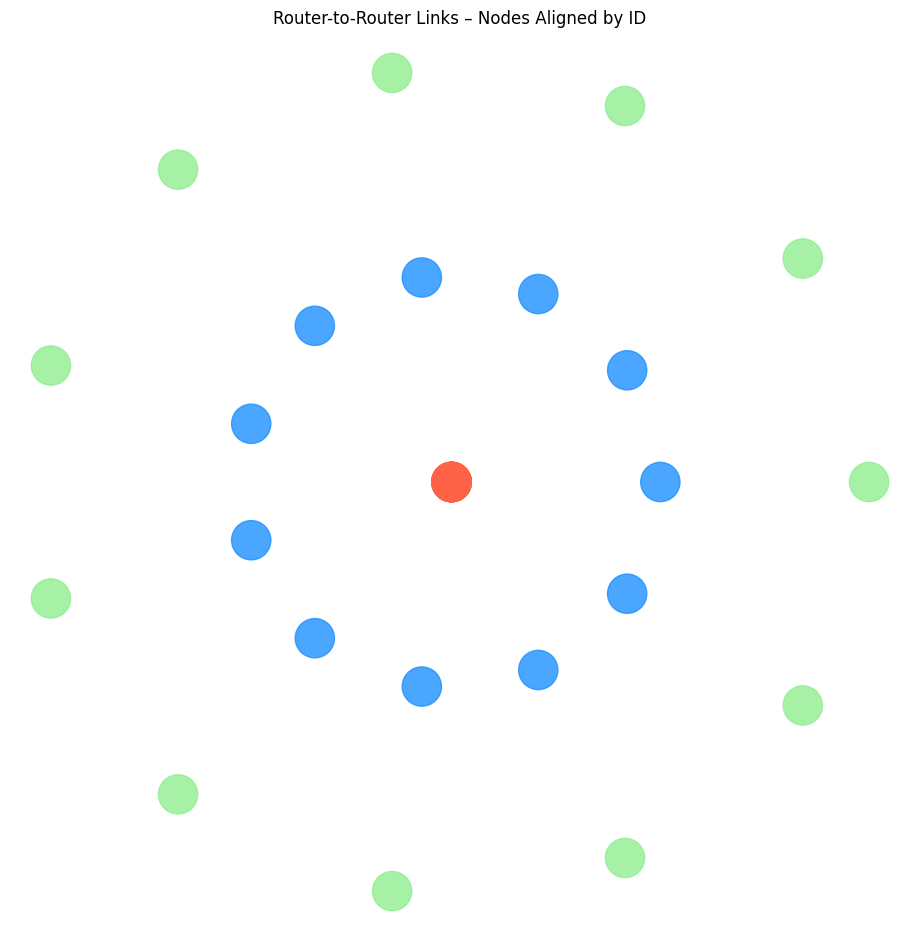

In [ ]:
import re, networkx as nx, matplotlib.pyplot as plt
from math import pi, cos, sin

link_data = """
s0-eth1 <-> r0-eth0  bw=Mbps  delay=  loss=%  q=
s1-eth1 <-> r1-eth0  bw=Mbps  delay=  loss=%  q=
s2-eth1 <-> r2-eth0  bw=Mbps  delay=  loss=%  q=
s3-eth1 <-> r3-eth0  bw=Mbps  delay=  loss=%  q=
s4-eth1 <-> r4-eth0  bw=Mbps  delay=  loss=%  q=
s5-eth1 <-> r5-eth0  bw=Mbps  delay=  loss=%  q=
s6-eth1 <-> r6-eth0  bw=Mbps  delay=  loss=%  q=
s7-eth1 <-> r7-eth0  bw=Mbps  delay=  loss=%  q=
s8-eth1 <-> r8-eth0  bw=Mbps  delay=  loss=%  q=
s9-eth1 <-> r9-eth0  bw=Mbps  delay=  loss=%  q=
s10-eth1 <-> r10-eth0  bw=Mbps  delay=  loss=%  q=
r0-eth1 <-> r1-eth1  bw=95.9785Mbps  delay=4.22315ms  loss=%  q=
r0-eth2 <-> r2-eth1  bw=98.0478Mbps  delay=7.6379ms  loss=%  q=
r0-eth3 <-> r3-eth1  bw=68.2662Mbps  delay=5.87145ms  loss=%  q=
r0-eth4 <-> r4-eth1  bw=99.3139Mbps  delay=6.8088ms  loss=%  q=
r0-eth5 <-> r5-eth1  bw=83.426Mbps  delay=4.4916ms  loss=%  q=
r0-eth6 <-> r6-eth1  bw=83.0869Mbps  delay=6.05765ms  loss=%  q=
r0-eth7 <-> r7-eth1  bw=60.7735Mbps  delay=7.14255ms  loss=%  q=
r0-eth8 <-> r8-eth1  bw=96.6157Mbps  delay=7.07675ms  loss=%  q=
r0-eth9 <-> r9-eth1  bw=92.9202Mbps  delay=6.418ms  loss=%  q=
r0-eth10 <-> r10-eth1  bw=97.8655Mbps  delay=5.82105ms  loss=%  q=
r1-eth2 <-> r2-eth2  bw=90.8298Mbps  delay=5.99835ms  loss=%  q=
r1-eth3 <-> r3-eth2  bw=71.2601Mbps  delay=4.2545ms  loss=%  q=
r1-eth4 <-> r4-eth2  bw=98.5978Mbps  delay=5.21835ms  loss=%  q=
r1-eth5 <-> r5-eth2  bw=85.2993Mbps  delay=4.41735ms  loss=%  q=
r1-eth6 <-> r6-eth2  bw=77.484Mbps  delay=5.5389ms  loss=%  q=
r1-eth7 <-> r7-eth2  bw=103.9588Mbps  delay=5.841ms  loss=%  q=
r1-eth8 <-> r8-eth2  bw=60.0515Mbps  delay=7.3222ms  loss=%  q=
r1-eth9 <-> r9-eth2  bw=102.1442Mbps  delay=4.90365ms  loss=%  q=
r1-eth10 <-> r10-eth2  bw=102.6049Mbps  delay=4.8864ms  loss=%  q=
r2-eth3 <-> r3-eth3  bw=86.4669Mbps  delay=4.9975ms  loss=%  q=
r2-eth4 <-> r4-eth3  bw=75.3185Mbps  delay=6.8805ms  loss=%  q=
r2-eth5 <-> r5-eth3  bw=77.7246Mbps  delay=5.7581ms  loss=%  q=
r2-eth6 <-> r6-eth3  bw=94.2362Mbps  delay=6.5448ms  loss=%  q=
r2-eth7 <-> r7-eth3  bw=103.9833Mbps  delay=7.5362ms  loss=%  q=
r2-eth8 <-> r8-eth3  bw=75.27Mbps  delay=5.28625ms  loss=%  q=
r2-eth9 <-> r9-eth3  bw=56.8118Mbps  delay=4.97055ms  loss=%  q=
r2-eth10 <-> r10-eth3  bw=61.234Mbps  delay=6.0824ms  loss=%  q=
r3-eth4 <-> r4-eth4  bw=96.2693Mbps  delay=4.4182ms  loss=%  q=
r3-eth5 <-> r5-eth4  bw=87.0909Mbps  delay=5.69355ms  loss=%  q=
r3-eth6 <-> r6-eth4  bw=63.4368Mbps  delay=6.7481ms  loss=%  q=
r3-eth7 <-> r7-eth4  bw=85.2728Mbps  delay=6.72625ms  loss=%  q=
r3-eth8 <-> r8-eth4  bw=66.2665Mbps  delay=6.4879ms  loss=%  q=
r3-eth9 <-> r9-eth4  bw=78.7714Mbps  delay=6.02505ms  loss=%  q=
r3-eth10 <-> r10-eth4  bw=90.7527Mbps  delay=7.1696ms  loss=%  q=
r4-eth5 <-> r5-eth5  bw=99.9713Mbps  delay=5.9879ms  loss=%  q=
r4-eth6 <-> r6-eth5  bw=57.2017Mbps  delay=4.3557ms  loss=%  q=
r4-eth7 <-> r7-eth5  bw=79.3775Mbps  delay=6.3829ms  loss=%  q=
r4-eth8 <-> r8-eth5  bw=95.2467Mbps  delay=7.5609ms  loss=%  q=
r4-eth9 <-> r9-eth5  bw=89.9151Mbps  delay=7.7912ms  loss=%  q=
r4-eth10 <-> r10-eth5  bw=99.5954Mbps  delay=6.6415ms  loss=%  q=
r5-eth6 <-> r6-eth6  bw=56.1264Mbps  delay=6.1324ms  loss=%  q=
r5-eth7 <-> r7-eth6  bw=85.0384Mbps  delay=4.937ms  loss=%  q=
r5-eth8 <-> r8-eth6  bw=90.9213Mbps  delay=6.3279ms  loss=%  q=
r5-eth9 <-> r9-eth6  bw=56.0351Mbps  delay=7.2403ms  loss=%  q=
r5-eth10 <-> r10-eth6  bw=82.5418Mbps  delay=4.67975ms  loss=%  q=
r6-eth7 <-> r7-eth7  bw=87.7056Mbps  delay=7.33665ms  loss=%  q=
r6-eth8 <-> r8-eth7  bw=84.1187Mbps  delay=5.45285ms  loss=%  q=
r6-eth9 <-> r9-eth7  bw=74.5212Mbps  delay=6.03995ms  loss=%  q=
r6-eth10 <-> r10-eth7  bw=85.3216Mbps  delay=4.3336ms  loss=%  q=
r7-eth8 <-> r8-eth8  bw=65.3389Mbps  delay=5.6012ms  loss=%  q=
r7-eth9 <-> r9-eth8  bw=57.8428Mbps  delay=7.2741ms  loss=%  q=
r7-eth10 <-> r10-eth8  bw=57.1245Mbps  delay=4.61785ms  loss=%  q=
r8-eth9 <-> r9-eth9  bw=96.8665Mbps  delay=7.1788ms  loss=%  q=
r8-eth10 <-> r10-eth9  bw=67.7031Mbps  delay=4.24145ms  loss=%  q=
r9-eth10 <-> r10-eth10  bw=63.7808Mbps  delay=4.74565ms  loss=%  q=
ubuntu0-eth0 <-> s0-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu1-eth0 <-> s1-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu2-eth0 <-> s2-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu3-eth0 <-> s3-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu4-eth0 <-> s4-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu5-eth0 <-> s5-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu6-eth0 <-> s6-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu7-eth0 <-> s7-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu8-eth0 <-> s8-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu9-eth0 <-> s9-eth2  bw=Mbps  delay=  loss=%  q=
ubuntu10-eth0 <-> s10-eth2  bw=Mbps  delay=  loss=%  q=
"""
raw = link_data
pat = re.compile(r'(\S+)\s+<->\s+(\S+)\s+bw=(\d*\.?\d*)')
edges, nodes = [], set()
for l in raw.splitlines():
    m = pat.search(l)
    if not m: continue
    i1,i2,bw = m.groups(); n1,n2 = i1.split('-')[0], i2.split('-')[0]
    bw = float(bw) if bw else None
    if n1.startswith('r') and n2.startswith('r'):        # solo router↔router
        edges.append((n1,n2,bw))
    nodes.update([n1,n2])

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from([(u,v,dict(bw=bw)) for u,v,bw in edges])

routers  = sorted([n for n in G if n.startswith('r')], key=lambda x:int(x[1:]))
switches = ['s'+r[1:] for r in routers]                 # s0…s10 allineati
hosts    = ['ubuntu'+r[1:] for r in routers]            # ubuntu0…ubuntu10 allineati

pos, r_inner, r_mid, r_outer = {}, 0, 1.5, 3.0
step = 2*pi/len(routers)
for i,r in enumerate(routers):
    ang = i*step
    pos[r]               = (r_inner*cos(ang),  r_inner*sin(ang))
    pos[switches[i]]     = (r_mid  *cos(ang),  r_mid  *sin(ang))
    pos[hosts[i]]        = (r_outer*cos(ang),  r_outer*sin(ang))

color = ['tomato' if n.startswith('r') else
         'dodgerblue' if n.startswith('s') else
         'lightgreen' for n in G]

w = [1 + (d['bw']/50 if d['bw'] else .5) for u,v,d in G.edges(data=True)]
lab = {(u,v):f"{d['bw']:.1f}M" for u,v,d in G.edges(data=True) if d['bw']}

plt.figure(figsize=(9,9))
nx.draw(G,pos,node_color=color,node_size=800,
        font_size=8,font_weight='bold',width=w,alpha=.8)

nx.draw_networkx_edge_labels(G,pos,edge_labels=lab,font_size=6)
plt.title("Router-to-Router Links – Nodes Aligned by ID")
plt.axis('off'); plt.tight_layout(); plt.show()
